In [2]:
from svae import SpikeSlabVAE, metrics, sparse_shift, sVAE
from scipy.stats import chi2_contingency
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import anndata as AnnData
import scrublet as scr
import seaborn as sns
import scvelo as scv
import cellrank as cr
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib
import anndata
import network
import networkx
import fsspec
import scvi
import h5py
import desc 
import umap
import igraph
import svae
import os
%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
sc.set_figure_params(figsize=(4, 4))
np.random.seed(42)

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


# Filtering the data

... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS152-OS152.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


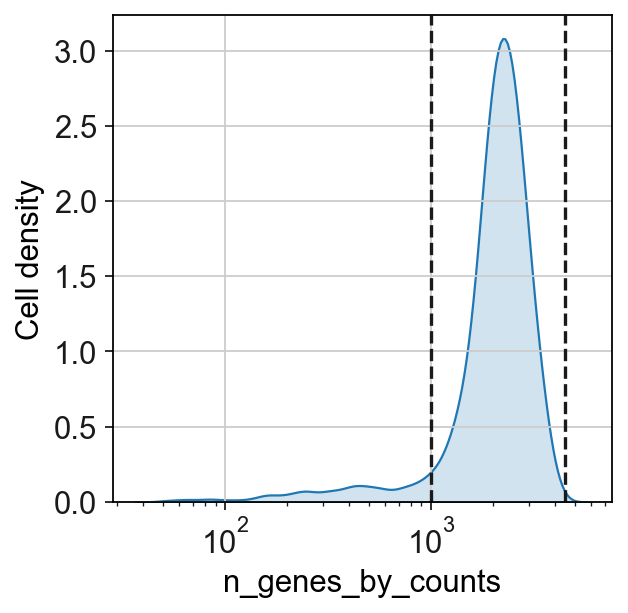

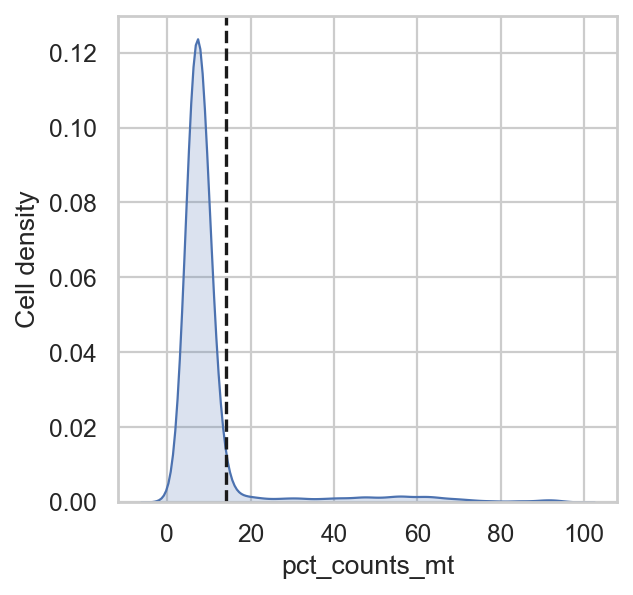

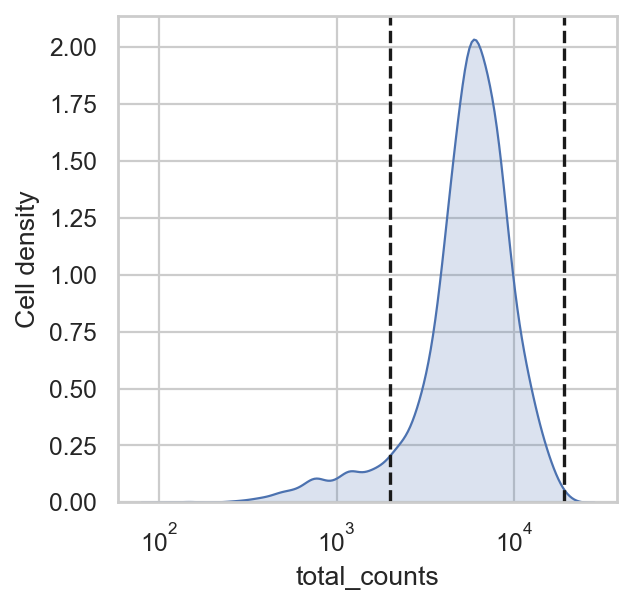

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_anndata.py:640: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"initial_size_{layer}"] = get_size(adata, layer)


Filtered out 53542 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1500 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
97
63
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    459 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    405 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished (0:00:07)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


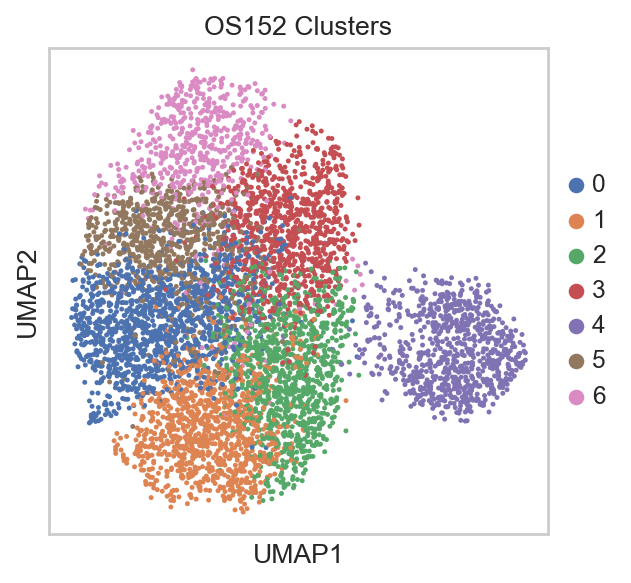

In [3]:
# reading in loom files
adata = scv.read('/Users/brendamelano/Desktop/10xver7/OS152/OS152.loom', cache = True)


# Ensuring that all variable names are unique
adata.var_names_make_unique()


# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)



## Filtering based on gene count
plt.figure()
sns.kdeplot(data=adata.obs, x='n_genes_by_counts', fill=True, alpha=0.2, log_scale=True)


# Add a vertical line at x = 20000
plt.axvline(x=4500, color='k', linestyle='--')
plt.axvline(x=1000, color='k', linestyle='--')


# Set labels and a classic theme
plt.xlabel("n_genes_by_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()




## Percent mitochondrial reads

#This may only show up correctly after filtering
plt.figure()
sns.kdeplot(data=adata.obs, x='pct_counts_mt', fill=True, alpha=0.2)

# Add a vertical line at x = 20000
plt.axvline(x=14, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("pct_counts_mt")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()




## Filtering based on total counts

plt.figure()
sns.kdeplot(data=adata.obs, x='total_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=2000, color='k', linestyle='--')
plt.axvline(x=19000, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("total_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()



# Filtering the dataset
# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 2000) &
                        (adata.obs['total_counts'] <= 19000) &
                        (adata.obs['n_genes_by_counts'] >= 1000) &
                        (adata.obs['n_genes_by_counts'] < 4500) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]


# Filtering genes based on minimum counts 
scv.pp.filter_genes(adata, min_shared_counts=20)


# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)
#sc.pp.normalize_total(adata, target_sum=1e4)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=1500)


# Log transformation
scv.pp.log1p(adata)


# preserving the counts
adata.layers["counts"] = adata.X.copy() 


# freezing the data in raw
# try moving to after selecting highly variable genes
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
# Research all the possible parameters for this
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)


genes = adata.var.index.values


# make sure this shouldn't come after the scale
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))


# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


# Computing the ccdifference score
adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']


#adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)

# Performing principal component analysis
sc.tl.pca(adata, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)

sc.tl.umap(adata)


sc.tl.leiden(adata, resolution = 0.8)

# Plotting the umap
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS152 Clusters",
    size = 20
)

# DGEA for leiden cluster

In [3]:
# Performing DGEA between clusters
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

# Creating a df for the cluster specific markers
cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)


cluster_markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


,0,1,2,3,4,5,6
0,RPS14,NRXN1,ID3,IGFBP7,RPL7,UBE2S,COL1A2
1,CIBAR1,IFITM5,FBN2,LGALS1,S100A4,HSP90AB1,COL1A1
2,NPW,MAD2L1,CLSPN,WIF1,BASP1,PTTG1,FTL
3,BARX1,TCEA3,PDIA4,LGALS3,LUM,HSP90AA1,S100A6
4,GAL,TAC3,TMSB4X,CAV1,HEY1,H2AC6,NEAT1
5,RPS18,SOST,HMGB2,MAP1B,MXRA8,PTMS,MALAT1
6,MCM7,ZFAND5,MALAT1,CALD1,CKB,CDC20,TPM1
7,CKS2,TUBB,NEFL,CRYAB,EPHX1,MARCKSL1,IGFBP7
8,CYBA,ALPL,CCNE2,FSTL1,FABP5,LMNA,PSAT1
9,TUBB,DUT,MT2A,S100A6,ELOC,JPT1,COL5A2


# Subtype A module identification

In [14]:
# Try to set this equal to the column that contains COL1A1 to automate it
cluster_id = '6'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS152_subtype_A_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS152_subtype_A_markers

,genes,p_values,adjusted_p_values,log_fold_changes,scores
32,ASS1,6.589402e-11,7.907282e-10,1.771494,6.529717
10,H2AC6,1.401833e-26,3.047462e-25,1.242891,10.670293
55,H2BC5,4.804971e-07,4.095146e-06,1.239072,5.033941
50,DDIT3,5.258183e-08,4.838819e-07,1.183624,5.442351
27,CITED2,2.811295e-13,3.699072e-12,1.161274,7.303140
35,TXNIP,1.109771e-10,1.300513e-09,1.157616,6.451188
44,KDM7A,9.459411e-09,9.522897e-08,1.145007,5.740148
31,STC2,2.575413e-11,3.115419e-10,1.080483,6.669006
49,PDGFRA,4.077144e-08,3.775133e-07,1.070619,5.487477
16,H2BC4,4.050563e-18,6.750938e-17,1.025639,8.677361


In [15]:
# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_A_markers.csv", OS152_subtype_A_markers, delimiter=",", fmt='%s')

OS152_subtype_A_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_A_markers.csv', header=None)

OS152_subtype_A_markers = OS152_subtype_A_markers.to_numpy()

OS742_subtype_A_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_A_markers.csv', header=None)

OS742_subtype_A_markers = OS742_subtype_A_markers.to_numpy()

OS384_subtype_A_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_A_markers.csv', header=None)

OS384_subtype_A_markers = OS384_subtype_A_markers.to_numpy()

# Convert numpy arrays of arrays into sets of tuples
set1 = set(tuple(map(tuple, OS384_subtype_A_markers)))
set2 = set(tuple(map(tuple, OS742_subtype_A_markers)))
set3 = set(tuple(map(tuple, OS152_subtype_A_markers)))

# Find common genes that appear in two or more lists
common_genes = (set1 & set2) | (set2 & set3) | (set1 & set3)

# Convert the set of tuples back to a list of lists (if necessary)
common_genes_list = [list(gene) for gene in common_genes]

common_genes_list

common_genes_array = np.array(common_genes_list).flatten()

# Convert the numpy array to a pandas DataFrame
common_genes_df = pd.DataFrame(common_genes_array, columns=['Gene'])

# Save the DataFrame to a CSV file
#common_genes_df.to_csv('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv', index=False)

computing score 'angiogenic_score'
    finished: added
    'angiogenic_score', score of gene set (adata.obs).
    108 total control genes are used. (0:00:00)


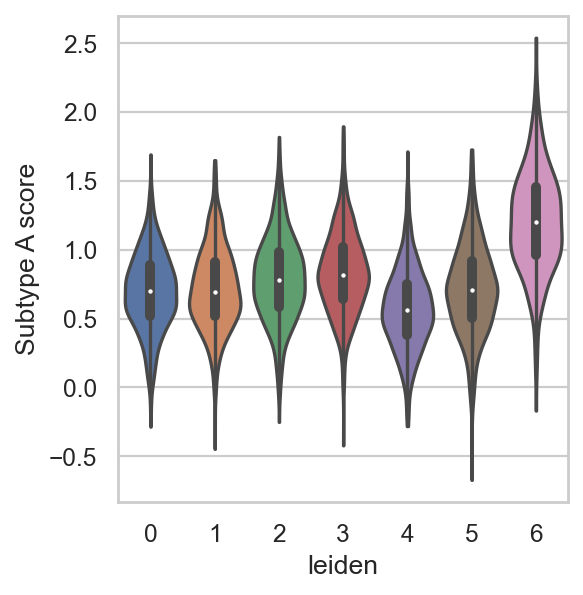

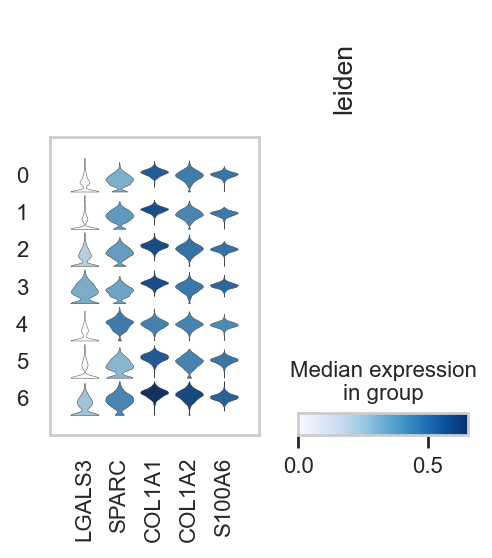

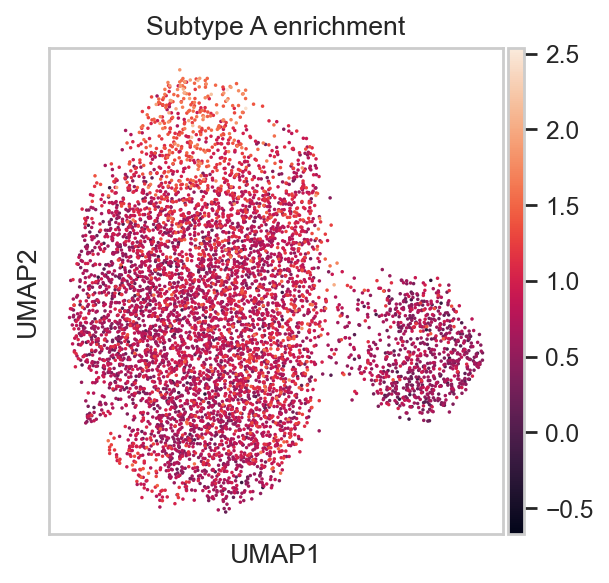

In [3]:
# reading in gene lists for gsea
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='angiogenic_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['angiogenic_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype A score')


sc.pl.stacked_violin(adata, Subtype_A_genes, groupby='leiden',
                     var_group_positions=[(7, 8)], var_group_labels=['leiden'],
                     standard_scale="var",)

sc.pl.umap(
    adata,
    color=["angiogenic_score"],
   # frameon=False,
    title = 'Subtype A enrichment',
    size = 10,
    legend_fontsize = 7
)

# Subtype B module identification

In [34]:
# Cluster IDs of interest
cluster_ids = [ '1','2']  # Adjust based on your clusters of interest

# Initialize empty lists to store data
genes_list = []
p_values_list = []
adjusted_p_values_list = []
log_fold_changes_list = []
scores_list = []

# Loop through each cluster to extract data
for cluster_id in cluster_ids:
    genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
    p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
    adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
    log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
    scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)
    
    # Append the extracted data for this cluster to the lists
    genes_list.append(genes)
    p_values_list.append(p_values)
    adjusted_p_values_list.append(adjusted_p_values)
    log_fold_changes_list.append(log_fold_changes)
    scores_list.append(scores)

# Concatenate data from all clusters of interest
cluster_markers = pd.concat([
    pd.DataFrame({
        'cluster_id': cluster_id,
        'genes': genes.values.flatten(),
        'p_values': p_values.values.flatten(),
        'adjusted_p_values': adjusted_p_values.values.flatten(),
        'log_fold_changes': log_fold_changes.values.flatten(),
        'scores': scores.values.flatten()
    }) for cluster_id, genes, p_values, adjusted_p_values, log_fold_changes, scores in zip(cluster_ids, genes_list, p_values_list, adjusted_p_values_list, log_fold_changes_list, scores_list)
], ignore_index=True)


# Sort the DataFrame by log_fold_changes in descending order
OS152_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS152_subtype_B_markers

OS152_subtype_B_markers = OS152_subtype_B_markers.iloc[:, 1].tolist()

OS152_subtype_B_markers

# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_B_markers.csv", OS152_subtype_B_markers, delimiter=",", fmt='%s')

OS152_subtype_B_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_B_markers.csv', header=None)

OS152_subtype_B_markers = OS152_subtype_B_markers.to_numpy()

OS384_subtype_B_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_B_markers.csv', header=None)

OS384_subtype_B_markers = OS384_subtype_B_markers.to_numpy()


OS742_subtype_B_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_B_markers.csv', header=None)

OS742_subtype_B_markers = OS742_subtype_B_markers.to_numpy()

In [20]:
# Convert numpy arrays of arrays into sets of tuples
set1 = set(tuple(map(tuple, OS384_subtype_B_markers)))
set2 = set(tuple(map(tuple, OS742_subtype_B_markers)))
set3 = set(tuple(map(tuple, OS152_subtype_B_markers)))

# Find common genes that appear in two or more lists
common_genes = (set1 & set2) | (set2 & set3) | (set1 & set3)

# Convert the set of tuples back to a list of lists (if necessary)
common_genes_list = [list(gene) for gene in common_genes]

common_genes_list

common_genes_array = np.array(common_genes_list).flatten()

# Convert the numpy array to a pandas DataFrame
common_genes_df = pd.DataFrame(common_genes_array, columns=['Gene'])

# Save the DataFrame to a CSV file
#common_genes_df.to_csv('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv', index=False)

# reading in gene lists for gsea
subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
subtype_B_genes = [x for x in subtype_B_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['Subtype_B_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype B score')


sc.pl.stacked_violin(adata, angiogenic_genes, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['leiden'],
                    standard_scale="var",)

sc.pl.umap(
    adata,
    color=["Subtype_B_score"],
   # frameon=False,
    title = 'Subtype B enrichment',
    size = 10,
    legend_fontsize = 7
)

[['AURKB'],
 ['TOP2A'],
 ['MAP1B'],
 ['HMGB2'],
 ['ASPM'],
 ['CENPF'],
 ['H2AZ1'],
 ['TYMS'],
 ['UBE2T'],
 ['MKI67'],
 ['CCNA2'],
 ['NDC80'],
 ['CDK1'],
 ['MAD2L1'],
 ['AURKA'],
 ['TUBB'],
 ['CLSPN'],
 ['GMNN'],
 ['H2AX'],
 ['TMPO'],
 ['TUBB4B'],
 ['UBE2C'],
 ['KPNA2'],
 ['USP1'],
 ['NCAPG'],
 ['CKS2'],
 ['SMC4'],
 ['ORC6'],
 ['ATAD2'],
 ['TUBA1B'],
 ['KIF23'],
 ['RAD51AP1'],
 ['ZWINT']]

# Subtype C module identification

In [4]:
# Cluster IDs of interest
cluster_ids = [ '4']  # Adjust based on your clusters of interest

# Initialize empty lists to store data
genes_list = []
p_values_list = []
adjusted_p_values_list = []
log_fold_changes_list = []
scores_list = []

# Loop through each cluster to extract data
for cluster_id in cluster_ids:
    genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
    p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
    adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
    log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
    scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)
    
    # Append the extracted data for this cluster to the lists
    genes_list.append(genes)
    p_values_list.append(p_values)
    adjusted_p_values_list.append(adjusted_p_values)
    log_fold_changes_list.append(log_fold_changes)
    scores_list.append(scores)

# Concatenate data from all clusters of interest
cluster_markers = pd.concat([
    pd.DataFrame({
        'cluster_id': cluster_id,
        'genes': genes.values.flatten(),
        'p_values': p_values.values.flatten(),
        'adjusted_p_values': adjusted_p_values.values.flatten(),
        'log_fold_changes': log_fold_changes.values.flatten(),
        'scores': scores.values.flatten()
    }) for cluster_id, genes, p_values, adjusted_p_values, log_fold_changes, scores in zip(cluster_ids, genes_list, p_values_list, adjusted_p_values_list, log_fold_changes_list, scores_list)
], ignore_index=True)


# Sort the DataFrame by log_fold_changes in descending order
OS152_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS152_subtype_C_markers = OS152_subtype_C_markers.iloc[:, 1].tolist()

OS152_subtype_C_markers

['BASP1',
 'DCN',
 'ZNF704',
 'HEY1',
 'PLAAT3',
 'MXRA8',
 'S100A4',
 'LUM',
 'PEX2',
 'TMEM70',
 'ZFHX4',
 'GNG4',
 'TERF1',
 'EPHX1',
 'KRT18',
 'ELOC',
 'XPR1',
 'RPL7',
 'FABP5',
 'CHMP4C',
 'SHOX2',
 'CHRM3',
 'PRRX1',
 'RDH10',
 'MLLT11',
 'RALGPS2',
 'LY6K',
 'MINDY2',
 'CLEC11A',
 'MME',
 'TIMP1',
 'KIFAP3',
 'CBR3',
 'TUBA1A',
 'FSCN1',
 'CKB',
 'IFITM5',
 'MAP1B',
 'CD24',
 'ATP2B1',
 'SQSTM1',
 'ENAH',
 'NPTX2',
 'MARCKSL1',
 'BTG1',
 'PCOLCE',
 'MIA3',
 'LMNA',
 'SNRNP200',
 'NEAT1',
 'SPARC',
 'CRYAB',
 'HSP90B1',
 'ANP32E',
 'TTC3',
 'S100A10',
 'HNRNPU',
 'NUCKS1',
 'FDPS',
 'RPL13A']

In [5]:
# Write the array to a CSV file
np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_C_markers.csv", OS152_subtype_C_markers, delimiter=",", fmt='%s')

OS152_subtype_C_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_C_markers.csv', header=None)

OS152_subtype_C_markers = OS152_subtype_C_markers.to_numpy()

OS384_subtype_C_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_C_markers.csv', header=None)

OS384_subtype_C_markers = OS384_subtype_C_markers.to_numpy()

OS742_subtype_C_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_C_markers.csv', header=None)

OS742_subtype_C_markers = OS742_subtype_C_markers.to_numpy()


# Convert numpy arrays of arrays into sets of tuples
set1 = set(tuple(map(tuple, OS384_subtype_C_markers)))
set2 = set(tuple(map(tuple, OS742_subtype_C_markers)))
set3 = set(tuple(map(tuple, OS152_subtype_C_markers)))

# Find common genes that appear in two or more lists
common_genes = (set1 & set2) | (set2 & set3) | (set1 & set3)

# Convert the set of tuples back to a list of lists (if necessary)
common_genes_list = [list(gene) for gene in common_genes]

common_genes_list

common_genes_array = np.array(common_genes_list).flatten()

# Convert the numpy array to a pandas DataFrame
common_genes_df = pd.DataFrame(common_genes_array, columns=['Gene'])

# Save the DataFrame to a CSV file
#common_genes_df.to_csv('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv', index=False)

# reading in gene lists for gsea
subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
subtype_C_genes = [x for x in subtype_C_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype C score')


sc.pl.stacked_violin(adata, subtype_C_genes, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['leiden'],
                    standard_scale="var",)


# Plotting markers

In [4]:
# Perform Differential Gene Expression Analysis
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

# Extract the names of the genes
gene_names = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)

# Extract Log Fold Change values
logfc = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges']).head(60)

# Filter for genes with LogFC > 1
filtered_genes = gene_names[logfc > 1].dropna()


# Extract gene names and log fold changes into a DataFrame
gene_names_df = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
logfc_df = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])

# Filter for logFC > 1. This involves checking each gene's logFC across all clusters
# and selecting the gene if it has logFC > 1 in any of the clusters.
filtered_genes = gene_names_df[logfc_df > 1].stack().reset_index(level=1, drop=True).unique()

print(filtered_genes)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [6]:
top_genes_across_clusters = []

# Get the number of clusters
# Assuming the cluster names are integers starting from 0
num_clusters = gene_names_df.shape[1]

# Loop over each cluster to get the top 10 genes based on logFC
for cluster_idx in range(num_clusters):
    # Sort the genes in descending order by their logFC for the current cluster
    sorted_genes = logfc_df.iloc[:, cluster_idx].sort_values(ascending=False).head(10).index
    
    # Retrieve the corresponding gene names for the top 10 logFC values
    top_genes = gene_names_df.iloc[sorted_genes, cluster_idx].values
    
    # Append these top genes to the list
    top_genes_across_clusters.extend(top_genes)

# Remove duplicates from the list, if any
top_genes_across_clusters = np.unique(top_genes_across_clusters)

print(top_genes_across_clusters)

['AK4' 'AMIGO2' 'ARHGAP28' 'ASNSP1' 'ASS1' 'BARX1' 'BASP1' 'BRIP1'
 'CASC15' 'CBLN2' 'CFAP251' 'CIBAR1' 'CIBAR1-DT' 'CLCN6' 'CLSTN2'
 'COL27A1' 'COL8A1' 'CRLF1' 'CYBA' 'DCN' 'DPYD' 'EFCAB7' 'EMP1'
 'ENSG00000231295' 'ENSG00000260658' 'ENSG00000285579' 'F2R' 'FGGY'
 'FRG1HP' 'GAL' 'GLRA3' 'H2AC6' 'HEY1' 'HMGA1P4' 'IBSP' 'IFI44' 'IGSF11'
 'ITGA11' 'KCNMB2-AS1' 'LINC01004' 'LRP1B' 'LRRN3' 'LUZP2' 'MAP2K6'
 'MARK1' 'MGLL' 'MPP4' 'NRXN1' 'NTM' 'OCLN' 'PCDH11X' 'PI15' 'PLK2'
 'PLXDC2' 'PTTG1' 'RIMS2' 'RNFT2' 'SERPINE1' 'SESN3' 'SFRP4' 'SKAP2'
 'SPP1' 'ST8SIA4' 'SULF1' 'TAC3' 'TEX14' 'VPS13B-DT' 'WFDC21P' 'ZNF704']


In [10]:
top_genes_by_cluster = {}  # Dictionary to hold top genes for each cluster

# Assuming gene_names_df and logfc_df have been correctly defined as before
num_clusters = gene_names_df.shape[1]

for cluster_idx in range(num_clusters):
    sorted_genes = logfc_df.iloc[:, cluster_idx].sort_values(ascending=False).head(10).index
    top_genes = gene_names_df.iloc[sorted_genes, cluster_idx].values
    top_genes_by_cluster[f"Cluster {cluster_idx}"] = top_genes
    

sc.pl.matrixplot(
    adata,
    top_genes_by_cluster,
    "leiden",
    #dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

In [1]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    with open(file_path, 'r') as file:
        genes = [x.strip() for x in file]
    return genes

Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')

# Combine gene lists from all subtypes, ensuring uniqueness if necessary
combined_genes = list(set(Subtype_A_genes + Subtype_B_genes + Subtype_C_genes))


In [17]:
Subtype_A_genes

['Gene', 'LGALS3', 'SPARC', 'COL1A1', 'COL1A2', 'S100A6']

In [5]:


# You might want to remove these missing genes from your list before plotting
combined_genes = [gene for gene in combined_genes if gene in adata.var_names]

# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]

Missing genes: ['ZWINT', 'Gene', 'USP1', 'H2AZ1', 'ORC6', 'RAD51AP1', 'TMPO', 'UBE2T', 'IFITM3', 'GMNN']


In [19]:
# Create the subtype dictionary again if not already created
subtype_A_dict = {gene: 'A' for gene in Subtype_A_genes}
subtype_B_dict = {gene: 'B' for gene in Subtype_B_genes}
subtype_C_dict = {gene: 'C' for gene in Subtype_C_genes}
subtype_dict = {**subtype_A_dict, **subtype_B_dict, **subtype_C_dict}

# Annotate the genes in adata with their subtype
adata.var['subtype'] = [subtype_dict.get(gene, 'Unknown') for gene in adata.var_names]

# Sort the genes in your subset by subtype
adata_subset = adata[:, adata.var_names.isin(combined_genes)]
adata_subset.var['subtype_order'] = adata_subset.var['subtype'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
adata_subset = adata_subset[:, adata_subset.var['subtype_order'].argsort()]

# Create a list of genes sorted by subtype for use in the matrixplot
sorted_genes_by_subtype = adata_subset.var_names.tolist()

/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_61303/2183499490.py:12: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_subset.var['subtype_order'] = adata_subset.var['subtype'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})


In [29]:
# Plotting the data with genes ordered by subtype
sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,
    groupby='leiden',
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS152 subtype markers",
    save="OS152_subtype_markers.svg",
    show=False  # Ensure the plot does not display prematurely
)

{'mainplot_ax': <Axes: >,
 'color_legend_ax': <Axes: title={'center': 'column scaled\nexpression'}>}

In [31]:
# Create a figure explicitly
plt.figure(figsize=(10, 8))  # You can adjust the size as needed

# Plotting with Scanpy on the created figure
ax = sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,  # Use the sorted list of genes
    groupby='leiden',
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS152 subtype markers",
    show=False  # Do not display the plot immediately
)

# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/OS152_subtype_markers.svg", format='svg')
plt.close()  # Close the plot to free up memory

<Figure size 800x640 with 0 Axes>

# pathway enrichment analysis

In [5]:
# Defining the directory for the gmt files
directory = '/Users/brendamelano/Desktop/gmt_files'

# Create a dictionary to store gene lists
gene_lists = {}

# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

# Create a dictionary to store gene scores for each module
gene_scores = {}

# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue



computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    189 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'


    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'CSR_genes_score'
    finished: added
    'CSR_genes_score', score of gene set (adata.obs).
    146 total control genes are used. (0:00:00)
computing score 'ESC_genes_score'
    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'


    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    192 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'EZH2_genes_score'
    finished: added
    'EZH2_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'LEF1_genes_score'
    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)


In [15]:


adata.var_names_make_unique()

# keeping only genes that appear in the adata
#VEGFA_genes = [x for x in VEGFA_genes if x in adata.var_names]
#print(len(VEGFA_genes))


# keeping only genes that appear in the adata
#PI3KAKTMTOR = [x for x in PI3KAKTMTOR if x in adata.var_names]
#print(len(PI3KAKTMTOR))

# computing gsea
sc.tl.score_genes(adata, VEGFA_genes, ctrl_size=50, gene_pool=None, n_bins=5, score_name='VEGFA_score', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['VEGFA_score'], groupby='leiden_scVI', stripplot=False, inner='box')

# GSEA for PI3K/AKT
# computing gsea
sc.tl.score_genes(adata, PI3KAKTMTOR, ctrl_size=50, gene_pool=None, n_bins=25, score_name='PI3KAKTMTOR', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['PI3KAKTMTOR'], groupby='leiden', stripplot=False, inner='box')


sc.pl.stacked_violin(adata, PI3KAKTMTOR, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['cluster'],
                    standard_scale="var",)



computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    189 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'


    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'CSR_genes_score'
    finished: added
    'CSR_genes_score', score of gene set (adata.obs).
    146 total control genes are used. (0:00:00)
computing score 'ESC_genes_score'
    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'


    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    192 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'OXPHOS_genes_score'
    finished: added
    'OXPHOS_genes_score', score of gene set (adata.obs).
    49 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'EZH2_genes_score'
    finished: added
    'EZH2_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'LEF1_genes_score'


    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)


KeyError: None

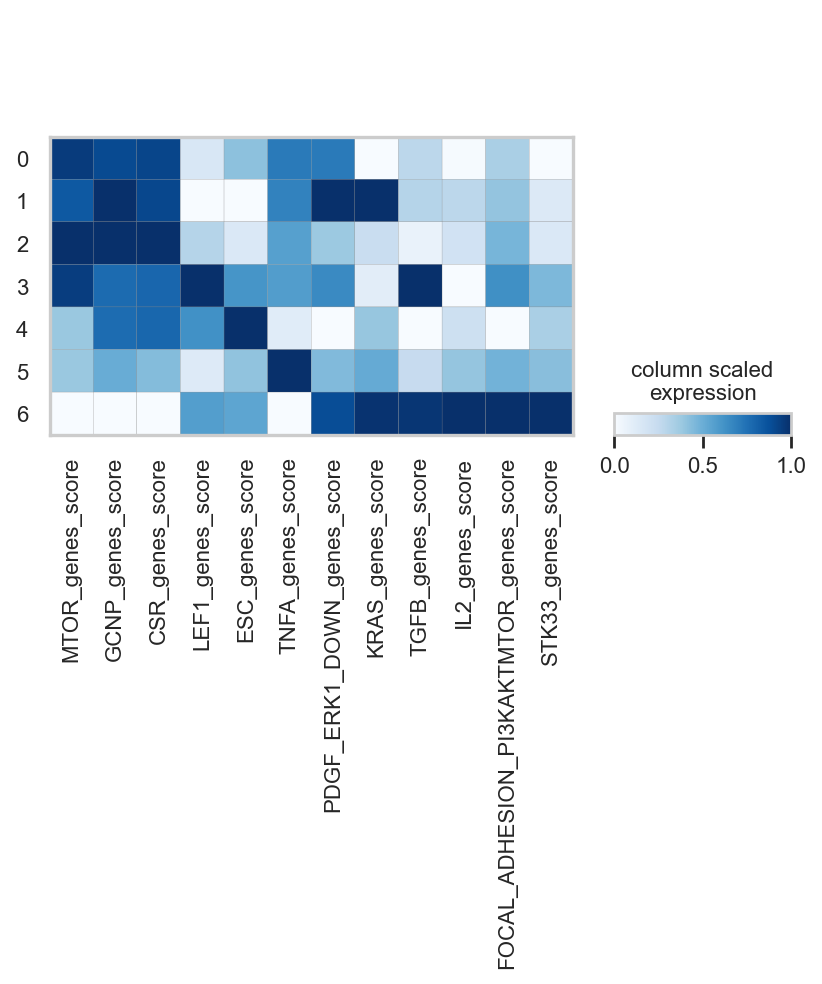

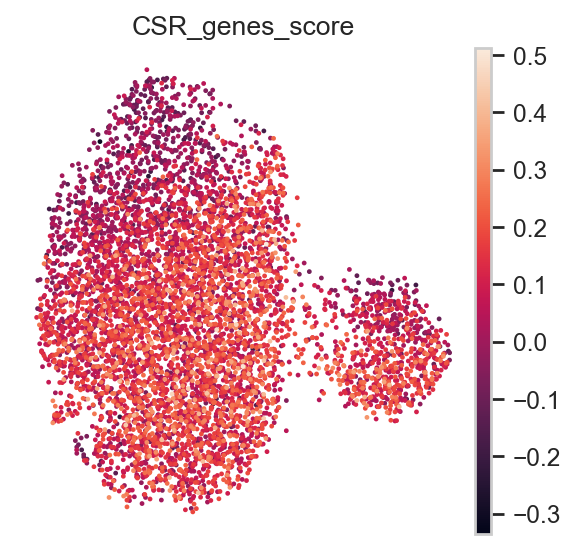

In [6]:
scores = [ 'MTOR_genes_score', 'GCNP_genes_score', 'CSR_genes_score',
            
          'LEF1_genes_score','ESC_genes_score','TNFA_genes_score','PDGF_ERK1_DOWN_genes_score',   
          'KRAS_genes_score', 'TGFB_genes_score','IL2_genes_score',  'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 
          'STK33_genes_score',]


sc.pl.matrixplot(
    adata,
    scores,
    "leiden",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)



# Labeling Subtypes

In [8]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')

adata.obs['leiden'][adata.obs['leiden']=='0']='1'

adata.obs['leiden'][adata.obs['leiden']=='4']='2'

adata.obs['leiden'][adata.obs['leiden']=='3']='5'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'esc': ['5'], 'immuneModulating': ['1'], 'angiogenic': ['2']}


# Initialize empty column in cell metadata
adata.obs['subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'subtype'] = i

    
sc.pl.umap(adata, color=['subtype'], legend_fontsize=9)

sc.pl.umap(adata, color=['leiden'], legend_fontsize=9)

# saving the adata file with the cluster ids
#adata.write("/Users/brendamelano/Desktop/os_data/OS152/scvi_152_adata_subtypes.h5ad")

sc.pl.stacked_violin(adata, ["UBE2C", "AURKA", "PLK1", "NUF2", "H4C3", "HEY1"], groupby = 'subtype')

# Performing DGEA between subtypes

In [74]:
# performing dgea between two subtypes
de_df = model.differential_expression(
    groupby='Subtype',
)


# identifying the top marklers within each cluster
markers = {}

cats = adata.obs.Subtype.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 1.2]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2] #originally 2
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]
    
    
# plotting the clusters
sc.pl.umap(
    adata,
    color=["Subtype"],
    frameon= True,
    title = "OS152 scVI embedding",
    size = 10
)

sc.pl.heatmap(
    adata, 
    markers, 
    groupby='Subtype', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

sc.pl.dotplot(adata, markers, 'Subtype', title = 'Subtype Markers')

sc.pl.dotplot(adata, markers, 'leiden_scVI', title = 'Subtype Markers')

# Labeling the Angiogenic Source and Terminal State

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


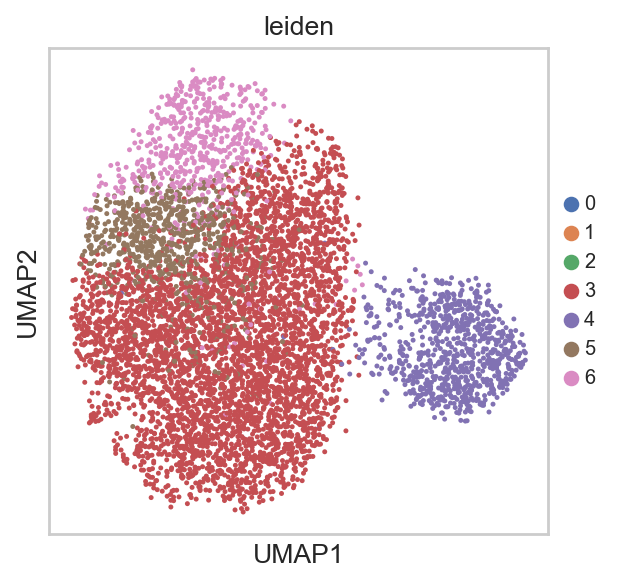

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


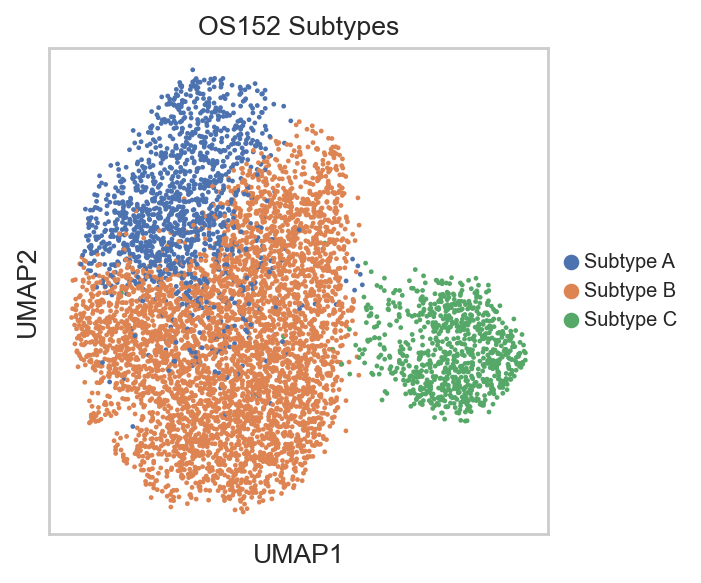

In [10]:
sc.pl.umap(adata, color=['leiden'], legend_fontsize=9, size = 20)

adata.obs['leiden'] = adata.obs['leiden'].astype('category')

adata.obs['leiden'][adata.obs['leiden']=='1']='3'
adata.obs['leiden'][adata.obs['leiden']=='0']='3'
adata.obs['leiden'][adata.obs['leiden']=='2']='3'
adata.obs['leiden'][adata.obs['leiden']=='5']='6'

# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['6'],  'Subtype B': ['3'], 'Subtype C':['4']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

    
# creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['Subtype'].values)

# Define the number of clusters
n_subtypes = len(subtypes[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)

# Create a dictionary that maps each cluster ID to a color from the palette
#subtype_colors = dict(zip(sorted(subtypes[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
#adata.uns['subtype_colors'] = [subtype_colors[c] for c in subtypes[0]]

sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9, title = "OS152 Subtypes") #, palette = subtype_colors

In [2]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/OS152_adata_labeled.h5ad")

adata = sc.read("/Users/brendamelano/Desktop/OS152_adata_labeled.h5ad")


# RNA velocity

In [18]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')



# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='Subtype', 
                                 palette=colors, title = 'OS152 RNA velocity embedding',
                                frameon = True)


# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden', 
                                 palette=colors, title = 'OS152 RNA velocity embedding',
                                frameon = True)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/283 [00:00<?, ?gene/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:03:18) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/6490 [00:00<?, ?cells/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# DGEA between subtypes

In [3]:
# performing dgea between two subtypes
de_df = model.differential_expression(
    groupby='Subtype',
    group1='Subtype B',
    group2='Subtype C'
)

de_df.head(25)

# Identifying the top markers within each cluster
markers = {}

cats = adata.obs.Subtype.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Subtype B".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 1]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2] #originally 2
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]
    
Subtype_B_genes = de_df.head(30)

Subtype_B_genes = de_df.head(30).index

sc.pl.stacked_violin(adata, ['ZNF704', 'HEY1', 'S100A4', 
       'TIMP1', 'LUM',
      'BASP1', 'MSX2',  'EPHX1',
          'ELOC',  'TMEM70'], groupby = 'Subtype',
                    title = ' OS152 Subtype B v C')

NameError: name 'model' is not defined

# DGE for Subtype A v subtype B

In [70]:
# performing dgea between two subtypes
de_df = model.differential_expression(
    groupby='Subtype',
    group1='Subtype A',
    group2='Subtype B'
)


# Identifying the top markers within each cluster
markers = {}

cats = adata.obs.Subtype.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Subtype A".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 1]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2] #originally 2
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]
    
Subtype_B_genes = de_df.head(30).index

sc.pl.dotplot(adata, Subtype_B_genes, 'Subtype', title = 'Subtype A v B')

# DGEA for source and terminal states of different trajectories

# comparing the esc source and terminal state

In [ ]:
## ESC subtype

# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'esc_source': ['3'], 'esc_terminal': ['5']}


# Initialize empty column in cell metadata
#adata.obs['esc_Source'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'source'] = i

    
sc.pl.umap(adata, color=['source'], legend_fontsize=9)

# performing dgea between two subtypes
de_df = model.differential_expression(
    groupby='esc_Source',
    group1='esc_source',
    group2='esc_terminal'
)

de_df.head(30)

## Immune modulating source and terminal state

# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'immuneModulating_Source': ['1'], 'ImmuneModulating_Terminal': ['0']}


# Initialize empty column in cell metadata
adata.obs['immuneModulating_Source'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'immuneModulating_Source'] = i

    
sc.pl.umap(adata, color=['immuneModulating_Source'], legend_fontsize=9)

# computing gsea
sc.tl.score_genes(adata, angi_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='angi_score', random_state=0, copy=False, use_raw=None)


sc.pl.violin(adata, ['angi_score'], groupby='subtype', stripplot=False, inner='box', rotation = 0.7)

# Chis-squared analysis for cell cycle

In [28]:
sc.pl.umap(
    adata,
    color=["phase"],
    frameon=True,
    title = 'OS152 Cell Cycle classification'
)

sc.pl.violin(adata, ['angiogenic_score'], groupby='Subtype', stripplot=False, inner='box', title = 'Subtype A enrichment in clusters', ylabel = 'Angiogenic Score')


# Small constant to avoid zero counts in the contingency table
epsilon = 1e-5
obs_data = adata.obs

# Create a contingency table
# Rows: depleted_10X status (True/False)
# Columns: Inside or outside cluster 3
contingency_table = pd.DataFrame(
    [
        [
            ((obs_data['phase'] == 'G1') & (obs_data['Subtype'] == 'Subtype A')).sum(),  # True in cluster 3
            ((obs_data['phase'] == 'G1') & (obs_data['Subtype'] != 'Subtype A')).sum(),  # True outside cluster 3
        ],
        [
            ((obs_data['phase'] != 'G1') & (obs_data['Subtype'] == 'Subtype A')).sum(),  # False in cluster 3
            ((obs_data['phase'] != 'G1') & (obs_data['Subtype'] != 'Subtype A')).sum(),  # False outside cluster 3
        ],
    ],
    index=["Phase_G1", "Phase_other"],
    columns=["Subtype A", "Other subtype"]
)

chi2, p, _, _ = chi2_contingency(contingency_table)


# If your data needs a small constant to be added to avoid issues with zeros, you can add it here
epsilon = 1e-10  # Or whatever small number is appropriate for your dataset
contingency_table += epsilon

# Perform chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Set a significance threshold (e.g., 0.05)
significance_threshold = 0.05

# Check if the result is significant
is_significant = p < significance_threshold

print(contingency_table)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Significant: {'Yes' if is_significant else 'No'}")

# Assuming 'barcode_data' is your DataFrame and 'depleted_10X' and 'leiden_scVI' are columns
# Calculate the proportions
Subtype_A_G1 = obs_data[(obs_data['Subtype'] == 'Subtype A') & (obs_data['phase'] == 'G1')]
Subtype_A_all = obs_data[obs_data['Subtype'] == 'Subtype A']

Subtype_B_C_G1 = obs_data[(obs_data['Subtype'] != 'Subtype A') & (obs_data['phase'] == 'G1')]
Subtype_B_C_all = obs_data[obs_data['Subtype'] != 'Subtype A']

prop_in_Subtype_A = len(Subtype_A_G1) / len(Subtype_A_all)
prop_outside_Subtype_A = len(Subtype_B_C_G1) / len(Subtype_B_C_all)

# Data to plot
categories = ['Subtype A', 'Subtype B and C']
proportions = [prop_in_Subtype_A, prop_outside_Subtype_A]

# Create bar chart
plt.figure(figsize=(5,5))
bars = plt.bar(categories, proportions, width=0.8, color=['#aec6cf', '#ffb6c1'])  # pastel blue and pink

# Add a border around the chart
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_color('black')

# Remove gridlines
plt.grid(False)

# Add labels and title (with p-value)
p_value = 1.410162683642539e-10
plt.ylabel('Proportion of cells in G1 state', fontsize=14)
plt.title(f'Proportion of G1 cells Within vs Outside Subtype A\n(p-value: {p_value:.2e})', fontsize=14)

# Add value labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', fontsize=14)  # va: vertical alignment, percentage formatting

plt.tight_layout()
plt.show()
